## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [1]:
import numpy as np
import random
import sys
import matplotlib.pyplot as plt
import pandas as pd

from utils import ReplayBuffer
from task import TakeOffTask
from agents.agent import DDPG

Using TensorFlow backend.


In [2]:
def train(task, agent, num_episodes):
    """
    Train the agent on the given task for num_episodes
    Output: 
      * total_rewards: list
      * scores: list
      * best_scores: list
    """
    
    total_rewards = []
    mean_total_rewards = []
    scores = []
    best_scores = []
    
    for i_episode in range(1, num_episodes + 1):
        state = agent.reset_episode() # start a new episode
        #print('starting new episode %s' % str(state))
        total_reward_per_episode = 0
        
        while True:
            action = agent.act(state) 
            next_state, reward, done = task.step(action)
            agent.step(action, reward, next_state, done)
            state = next_state
            total_reward_per_episode += reward
            
            if done:
                # Update performance metrics
                total_rewards.append(total_reward_per_episode)
                new_mean_total_rewards = np.mean(total_rewards[-10:])
                mean_total_rewards.append(new_mean_total_rewards)
                
                print("\rEpisode = {:4d}, total_reward = {:7.3f}, mean_total_rewards = {:7.3f}".format(
                    i_episode, total_reward_per_episode, new_mean_total_rewards), end="")  # [debug]
                break
                
        sys.stdout.flush()
        
    return total_rewards, mean_total_rewards, best_scores

In [3]:
def plot_agent_training_performance(total_rewards, scores):
    """
    Plot Agent Performance
    """
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(7,10))
    
    ax1.plot(total_rewards)
    ax1.set_title('Total Rewards')
    
    ax2.plot(scores)
    ax2.set_title('Scores')

In [4]:
# Parameters
num_episodes = 100
actor_params = {'lr': .0001}
critic_params= {'lr': .001}
noise_params= {'mu': 0, 'theta': .15, 'sigma': .2}
replay_memory_params= {'buffer_size': 100000, 'batch_size': 64}
algo_params = {'gamma': .99, 'tau': .1}

# Initializing Task
target_z_pos = 10.
init_pose = np.array([0., 0., 1., 0., 0., 0.])
takeOffTask = TakeOffTask(
    target_z_pos=target_z_pos, 
    init_pose=init_pose
)

# Initializing Agent
agent = DDPG(
    takeOffTask,
    actor_params=actor_params,
    critic_params=critic_params,
    noise_params=noise_params,
    replay_memory_params=replay_memory_params,
    algo_params=algo_params
)

Episode =  100, total_reward = -27.000, mean_total_rewards = -25.200

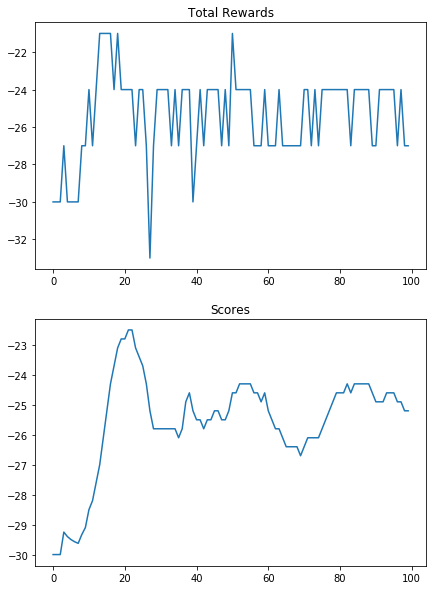

In [5]:
total_rewards, scores, _ = train(takeOffTask, agent, num_episodes)
plot_agent_training_performance(total_rewards, scores)

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

In [6]:
def plot_simulation(results):
    """
    Plot the simulation results
    """
    
    fig, ((ax1, ax2), (ax3, ax4), (ax5, _)) = plt.subplots(nrows=3, ncols=2, figsize=(25,17))
    
    ax1.plot(results['time'], results['x'], label='x')
    ax1.plot(results['time'], results['y'], label='y')
    ax1.plot(results['time'], results['z'], label='z')
    ax1.legend()
    ax1.set_title('Position')
    
    ax2.plot(results['time'], results['x_velocity'], label='x_hat')
    ax2.plot(results['time'], results['y_velocity'], label='y_hat')
    ax2.plot(results['time'], results['z_velocity'], label='z_hat')
    ax2.legend()
    ax2.set_title('Velocity')
    
    ax3.plot(results['time'], results['phi'], label='phi')
    ax3.plot(results['time'], results['theta'], label='theta')
    ax3.plot(results['time'], results['psi'], label='psi')
    ax3.legend()
    ax3.set_title('Euler Angles')
    
    ax4.plot(results['time'], results['phi_velocity'], label='phi_velocity')
    ax4.plot(results['time'], results['theta_velocity'], label='theta_velocity')
    ax4.plot(results['time'], results['psi_velocity'], label='psi_velocity')
    ax4.legend()
    ax4.set_title('Euler Angle Velocity')
    
    ax5.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
    ax5.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
    ax5.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
    ax5.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
    ax5.legend()
    ax5.set_title('Actions')

In [7]:
def simulate_agent(task, agent):
    """
    Simulate agent for the given task
    """
    
    done = False
    labels = [
        'time',
        
        # pose
        'x', 
        'y', 
        'z', 
        'phi', 
        'theta', 
        'psi', 
        
        # velocity
        'x_velocity',
        'y_velocity', 
        'z_velocity', 
        
        # angular velocity
        'phi_velocity', 
        'theta_velocity',
        'psi_velocity', 
        
        # rotor speeds
        'rotor_speed1', 
        'rotor_speed2', 
        'rotor_speed3', 
        'rotor_speed4'
    ]
    
    results = {x : [] for x in labels}
    _ = task.reset()
    
    state = agent.reset_episode() # start a new episode
    
    # Run the simulation
    while True:
        rotor_speeds = agent.act(state)
        next_state, _, done = task.step(rotor_speeds)
            
        results = append_simulation_result(
            labels,
            results,
            task.sim.time, 
            task.sim.pose,
            task.sim.v,
            task.sim.angular_v,
            rotor_speeds
        )
        
        if done:
            break
            
        state = next_state
            
    return results


def append_simulation_result(labels, results, time, pose, v, angular_v, rotor_speeds):
    
    to_write = [time]  \
                + list(pose)  \
                + list(v)  \
                + list(angular_v)  \
                + list(rotor_speeds) 
                    
    for ii in range(len(labels)):
        results[labels[ii]].append(to_write[ii])
        
    return results

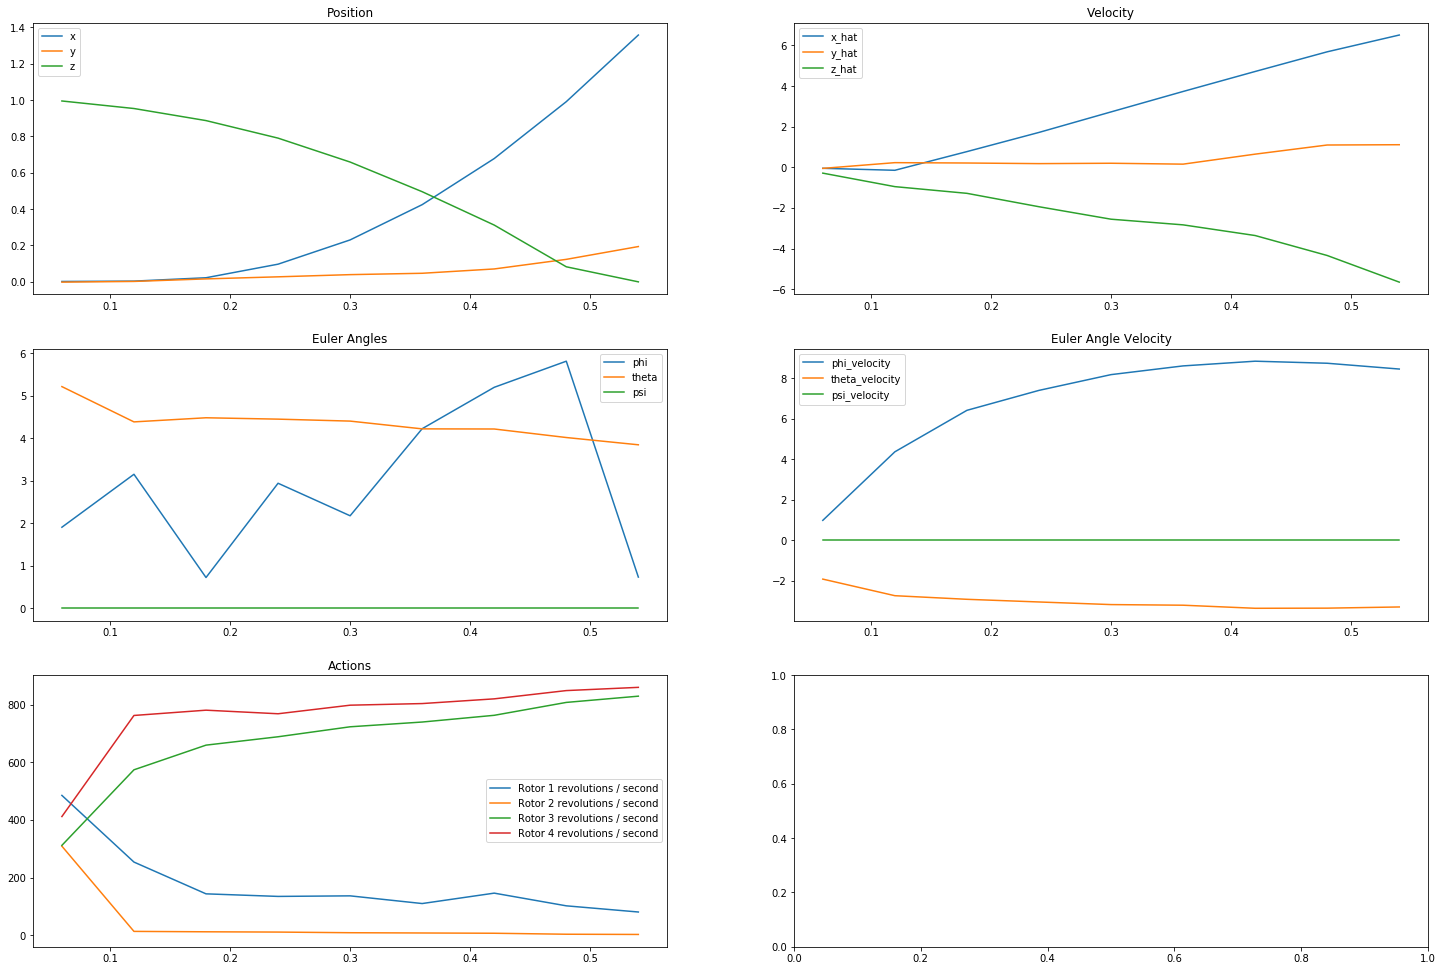

In [8]:
simulation_results = simulate_agent(takeOffTask, agent)
plot_simulation(simulation_results)

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**: 
I specified a TakeOffTask in `task.py`. The `init_pose` used in the simulator is defined as follows: `np.array([0., 0., 0., 0., 0., 0.])`. I add a `target_z_pos` which represents the altitude that the quadcoptere must reach to achieve a proper take off. It is set to `10.` in the TakeOffTask.

Here is my reward function:
```python
def get_reward(self, done):
    crash_reward = -1.

    # Penalizes crash
    if done and self.sim.time < self.sim.runtime:
        return crash_reward

    z = self.sim.pose[2]
    vz = self.sim.v[2]
    target_z = self.target_z_pos

    constant_reward = 1.
    position_reward = -0.3 * np.linalg.norm(z - target_z)
    velocity_reward = .5 if vz > 0. else -0.25
    final_reward = constant_reward + position_reward + velocity_reward

    return np.clip(final_reward, -1., 1.)

```
The reward function is the combination of the following reward terms:
- a constant reward of `1.` for survival 
- a position reward `position_reward = -0.3 * np.linalg.norm(z - target_z)` that gets closer to 0 as the quadcopter altitute gets closer to the target
- a velocity reward `velocity_reward = .5 if vz > 0. else -0.25` that gets a constant reward of `0.5` if the z velocity is positive
- a crash reward. If the quadcopter crashes or the episode ends, the reward is `-1`

The reward is also clipped between `-1.` and `1.`

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:
- I used the DDPG algorithm
- The following Hyperparameters are used:
  - `gamma`: 0.99
  - `tau`: 0.01 for soft updates
  - `batch_size`: 64
  - `buffer_size` for replay memory: 100000
- NN architectures
  - Actor
    - Sequence of Dense layers with ReLU: 32, 64, 32
    - final units are scaled in `(action_low, action_high)` range
  - Critic
    - Sequence of Dense layers with ReLU: 32, 64
    - Final Unit is the q value (combining actions and states networks)

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:

- The TakeOffTask was a hard task to learn
- I tried different NN architectures and hyperparameters as it is reflected in my code (where I can just pass down parameters I want to try). I think the hard part is just to make sure all the pieces fit together and the actor-critic model actually learn something.
- The final performance of the agent is still not that good. the mean rewards over the last 10 episodes is `-5`

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:

* The hardest part for me was to make sure pieces were fitting together
* Reinforcement Learning can be really hard especially with continuous action spaces when an actor-critic method can be used.